In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.eda_methods import show_barplot, load_data, load_data_all
from pandas.plotting import register_matplotlib_converters
from scipy.stats import boxcox, skew, shapiro, probplot, ttest_rel
from sklearn import preprocessing

pd.set_option('display.max_colwidth', 125)
register_matplotlib_converters()

In [2]:
# IMPORTANT - Figure out how to correctly convert old hashes to new hashes

# project_name = 'zeppelin'
# try:
#     tmp =\
#         pd.read_csv(
#             'assets/data/{0}/new_{0}_commits.csv'.format(project_name),
#             nrows=None,
#             header=None
#         )
# except UnicodeDecodeError:
#     tmp =\
#         pd.read_csv(
#             'assets/data/{0}/new_{0}_commits.csv'.format(project_name),
#             nrows=None,
#             header=None,
#             encoding='utf-16'
#         )
# tmp = tmp.set_index(0).apply(pd.to_datetime, axis=1)
# tmp['dates_match'] = tmp.apply(lambda x: x.duplicated().sum(), axis=1).astype('bool')

# # finds
# grouped = tmp.groupby(2)
# g_index =\
#     [
#             x for x in grouped[1].apply(
#                 lambda x: pd.to_datetime(x[0], utc=True) 
#                 if (x.count() > 1).sum() else ''
#             ).values if x
#     ]
# tmp = tmp.reset_index().set_index(1)
# tmp.index = pd.to_datetime(tmp.index, utc=True, infer_datetime_format=True)

# transforms date column into datetime_index
# new_commits =\
#     pd.Series(
#         tmp[0].values,
#         index=pd.to_datetime(
#                 tmp[1].values,
#                 infer_datetime_format=True,
#                 utc=True
#             )
#     )
# new_commits.name = project_name

In [3]:
old, new, cc, bic = load_data_all()

In [4]:
# shows duplicated bug introducing commits (BIC) for each project
print('Total and duplicated bug introducing commits (BIC) for each project:\n\n\t\t\t(total, duplicated)')
bic.groupby(level=0).apply(lambda x: (x.count(), x.duplicated().sum()))

Total and duplicated bug introducing commits (BIC) for each project:

			(total, duplicated)


accumulo                      (3603, 2828)
activemq                      (8803, 7157)
ambari                      (47658, 40607)
avro                           (1099, 797)
beam                          (5690, 3538)
calcite                       (9083, 7843)
camel                        (10091, 6687)
cassandra                   (52036, 48730)
commons-lang                  (1503, 1003)
cordova-android                (1435, 922)
cxf                           (4902, 3446)
eagle                           (689, 456)
fineract                       (1051, 634)
flink                         (4421, 2765)
geode                        (10888, 9437)
groovy                      (17500, 14629)
james-project                  (1019, 511)
jena                            (930, 594)
kafka                         (1875, 1174)
karaf                         (1795, 1218)
kylin                         (3278, 2280)
lucene-solr                   (9854, 6606)
mahout                        (1824, 1198)
maven      

In [5]:
# removes duplicated BICs
print('Total BICs after removal of duplicates:\n')

project_bic = bic.groupby(level=0)

# saves unique BICs
ubic = project_bic.apply(lambda x: x.drop_duplicates(keep='first')).droplevel(0, axis=0)

print(ubic.groupby(level=0, axis=0).count())
# del bic

Total BICs after removal of duplicates:

accumulo                     775
activemq                    1646
ambari                      7051
avro                         302
beam                        2152
calcite                     1240
camel                       3404
cassandra                   3306
commons-lang                 500
cordova-android              513
cxf                         1456
eagle                        233
fineract                     417
flink                       1656
geode                       1451
groovy                      2871
james-project                508
jena                         336
kafka                        701
karaf                        577
kylin                        998
lucene-solr                 3248
mahout                       626
maven                       1331
netbeans                      70
nifi                         896
nutch                        315
ofbiz                       1151
parquet-mr                   151
ph

In [6]:
# '''
# shows all conflicting 'created_at' commits
# proceed with manual investigation of how to solve this (HUGE ISSUE!!!)
# '''
# old.droplevel(0, axis=0)[old.droplevel(0, axis=0).index.duplicated(keep=False)]
# new.droplevel(0, axis=0)[new.droplevel(0, axis=0).index.duplicated(keep=False)]

In [7]:
# new.reset_index().iloc[old.reset_index().index][0].values
'''
prints projects with different number of commits
'''
new_g = new.groupby(level=0)
old_g = old.groupby(level=0)

for ng, og in zip(new_g, old_g):
    # ng[1] = ng[1][ng[1].index.isin(og[1].index)]
    if len(ng[1])-1 != len(og[1]):
        print(ng[0], (len(ng[1]) - len(og[1]))-1)

camel 96
lucene-solr 30
netbeans 2


In [8]:
# '''
# ensures that only commits present in 'old' are considered
# '''
# new_g = new.groupby(level=0)
# old_g = old.groupby(level=0)
# tmp = []

# for ng, og in zip(new_g, old_g):
#     tmp.append(ng[1][ng[1].index.isin(og[1].index)])

# new = pd.concat(tmp)
# del tmp
# del new_g, old_g

In [9]:
# drops the latest commit of each project, since it is actually from the tool not the project itself
new = new_g.apply(lambda x: x.iloc[1:]).droplevel(0)

In [10]:
# aggregates old and new commits to facilitate conversion
convert = pd.DataFrame()

convert['old_hash'] = old
convert['new_hash'] =\
    new.reset_index()\
    .iloc[old.reset_index()\
    .index][0].values

# converts bic commits to their equivalent in 'new'
nbic =\
    convert.set_index('old_hash')\
    .squeeze()[ubic.values]\
    .dropna()\
    .reset_index(drop=True)

del convert

In [11]:
'''
selects relevant support count (>1) and confidence (>=0.5)
'''
# selects cochange of at least two components with confidence higher that 0.5
rcc = cc[
    (cc.support_count > 1) & (cc.confidence >= 0.5)
].reset_index(drop=True)

print(
    'Selects components with relevant cochange dependency\n',
    'Of {0} entries, {1} ({2:.2f}%) were found to have support_count > 1 and confidence >= 0.5'
    .format(len(cc), len(rcc), (100*len(rcc)/len(cc)))
)

del cc

Selects components with relevant cochange dependency
 Of 8932894 entries, 312681 (3.50%) were found to have support_count > 1 and confidence >= 0.5


In [28]:
{1,2,3,4,5,6} - {1,2,3}

{4, 5, 6}

In [33]:
import itertools

# operates with sets due to performance gains
set_rcc = set(itertools.chain.from_iterable(rcc['commit_hash'].values))
set_bic = set(bic.values)

# defines implicit functions to compute count and percentage metrics
get_total_bic_count = lambda x: len(set_bic) - (len(set_bic - set(x.values)))
get_total_bic_percent = lambda x: (len(set_bic) - (len(set_bic - set(x.values)))) / len(x)

get_cochange_count = lambda x: len(set(x.values) & set(set_rcc))
get_cochange_bic_count = lambda x: len(set(x.values) & set(set_rcc) & set(nbic.values))
get_cochange_bic_percent = lambda x:\
    len(set(x.values) & set(set_rcc) & set(nbic.values)) / len(set(x.values) & set_rcc) if len(set(x.values) & set_rcc) != 0 else 0.0

get_nocochange_count = lambda x: len(set(x.values) - set(set_rcc))
get_nocochange_bic_count = lambda x: len((set(x.values) - set(set_rcc)) & set(nbic.values))
get_nocochange_bic_percent = lambda x:\
    len((set(x.values) - set(set_rcc)) & set(nbic.values)) / len(set(x.values) - set_rcc) if len(set(x.values) & set_rcc) != 0 else 0.0

# applies count functions over each group (project)
total_bic_df =\
    old_g.agg(['count', get_total_bic_count, get_total_bic_percent])\
    .rename(columns={
        '<lambda_0>': 'bic_count', '<lambda_1>': 'bic_percent'
    })

cc_bic_df =\
    new_g.agg([get_cochange_count, get_cochange_bic_count, get_cochange_bic_percent])\
    .rename(columns={
        '<lambda_0>': 'cochange_count', '<lambda_1>': 'bic_count', '<lambda_2>': 'bic_percent'
    })

nocc_bic_df =\
    new_g.agg([get_nocochange_count, get_nocochange_bic_count, get_nocochange_bic_percent])\
    .rename(columns={
        '<lambda_0>': 'nocochange_count', '<lambda_1>': 'bic_count', '<lambda_2>': 'bic_percent'
    })

## Assumptions of the paired t-test
* The dependent variable (DV) must be continuous which is measured on an interval or ratio scale
* The DV should not contain any significant outliers
* The DV should be approximately normally distributed
    * Testing for normality needs to be conducted on the differences between the two conditions, not the raw values of each condition itself
    * If there is a violation of normality, as long as it’s not in a major violation, the test results can be considered valid

In [14]:
'''
Assumption 2. Outliers
'''
mean = cc_bic_df['bic_percent'].mean()
std = cc_bic_df['bic_percent'].std()
cc_bic = cc_bic_df['bic_percent'][cc_bic_df['bic_percent'].apply(lambda x: (x > mean - 2*std) and (x < mean + 2*std))]

mean = total_bic_df['bic_percent'].mean()
std = total_bic_df['bic_percent'].std()
total_bic = total_bic_df['bic_percent'][total_bic_df['bic_percent'].apply(lambda x: (x > mean - 2*std) and (x < mean + 2*std))]

In [15]:
print(
    '\t\t---Summary of Variables---\n\n',
    'Percentage of BICs in all commits:\n',
    total_bic.describe(),
    '\n------------------------------------------------------\n'
    '\nPercentage of BICs in commits with cochange dependency:\n',
    cc_bic.describe(),
)

---Summary of Variables---

 Percentage of BICs in all commits:
 count    35.000000
mean      0.108511
std       0.050879
min       0.000205
25%       0.073946
50%       0.099504
75%       0.137217
max       0.221905
Name: percent, dtype: float64 
------------------------------------------------------

Percentage of BICs in commits with cochange dependency:
 count    36.000000
mean      0.098130
std       0.063570
min       0.000000
25%       0.048638
50%       0.101623
75%       0.133526
max       0.257143
Name: percent, dtype: float64


In [16]:
'''
test both samples for normality
'''
print(
    '\t\t---Shapiro Wilk Normality Test - Individual Samples---\n',
    '\tAssume normality if p-value > 0.05\n\n'
    '\t\tTotal BICs\n W-statistic\t\tp-value\n',
    shapiro(total_bic.values),
    '\n\n\t\tCochange BICs\n W-statistic\t\tp-value\n',
    shapiro(cc_bic.values)
)

---Shapiro Wilk Normality Test - Individual Samples---
 	Assume normality if p-value > 0.05

		Total BICs
 W-statistic		p-value
 (0.9772871732711792, 0.6693524122238159) 

		Cochange BICs
 W-statistic		p-value
 (0.9681053161621094, 0.37607207894325256)


In [17]:
'''
pairs the two variables
'''
total_bic = total_bic[total_bic.index.isin(cc_bic.index)]
cc_bic = cc_bic[cc_bic.index.isin(total_bic.index)]

---Shapiro Wilk Normality Test - Paired Samples---
 	Assume normality if p-value > 0.05

	Difference of BICs (total - cocahnge)
 W-statistic		p-value
 (0.9722103476524353, 0.5250150561332703) 




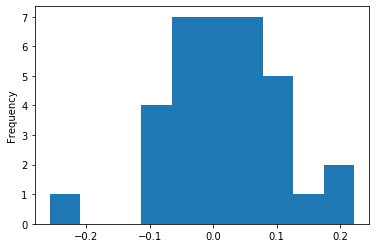

In [25]:
'''
Assumption 3. Normality of the differences
'''
bic_diff = total_bic - cc_bic
print(
    '\t\t---Shapiro Wilk Normality Test - Paired Samples---\n',
    '\tAssume normality if p-value > 0.05\n\n'
    '\tDifference of BICs (total - cocahnge)\n W-statistic\t\tp-value\n',
    shapiro(bic_diff.values),
    '\n\n'
)
bic_diff.plot(kind='hist')
plt.show()

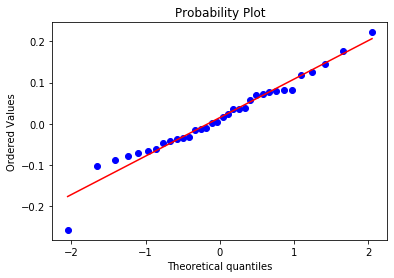

In [19]:
plot = probplot(bic_diff, plot=plt)

### Normality can be assumed.

In [20]:
ttest_rel(total_bic, cc_bic)

Ttest_relResult(statistic=0.9637708999732242, pvalue=0.34217056660914646)

## Assumptions of the unpaired t-test

* Assumption of independence
* Assumption of normality: the dependent variable should be continuous and approximately normally distributed.
* Assumption of homogeneity of variance: The variances of the dependent variable should be equal.



In [21]:
# def transform_skew(df: pd.DataFrame) -> pd.DataFrame:
#     '''
#     Transforms data with Boxcox transformation
#     Keeps the transformation only if it is less skewed than the original
#     '''
#     data = df.values
#     posdata = data[data > 0]
#     # posdata = eda.data[eda.data[feat]>0][feat]

#     x, lmbda = boxcox(posdata, lmbda=None)
    
#     transform = np.empty_like(data)
#     transform[data > 0] = x
#     transform[data == 0] = -1/lmbda

#     if abs(skew(transform)) < abs(skew(data)):
#         return transform

#     else:
#         return data

In [22]:
# '''
# standardizes (and transforms skewness)
# '''
# print('> performs standardization on both variables...')
# std_cc_bic = preprocessing.scale(cc_bic)
# std_total_bic = preprocessing.scale(total_bic)

In [23]:
# print(
#     '\t\t---Shapiro Wilk Normality Test - Individual Samples---\n',
#     'Assume normality if p-value > 0.05\n\n'
#     '\t\tTotal BICs\n W-statistic\t\tp-value\n',
#     shapiro(std_total_bic),
#     '\n\n\t\tCochange BICs\n W-statistic\t\tp-value\n',
#     shapiro(std_cc_bic)
# )

In [24]:
# bic_diff = std_total_bic - std_cc_bic
# print(
#     '\t\t---Shapiro Wilk Normality Test---\n',
#     'Assume normality if p-value > 0.05\n\n'
#     '\t\tDifference of BICs (total - cocahnge)\n W-statistic\t\tp-value\n',
#     shapiro(bic_diff),
#     '\n\n'
# )
# print(pd.Series(bic_diff).plot(kind='hist'))

In [12]:
# set(new.values) & set_rcc & set(nbic.values)
# new_g.apply(lambda x: len(set(x.values) & set(set_rcc) & set(nbic.values)))